In [1]:
#Creation of the dependent and independent terms
import numpy as np
nsample=30    #Number of observations
nvariables=5  #Number of variables
#We make results reproducible in order to obtain always the same random values
np.random.seed(0) 
X0=np.ones([nsample,1])
X1=np.random.uniform(0,10,([nsample,nvariables]))
X=np.concatenate([X0,X1],axis=1)  #Design Matrix
error=np.random.normal(0,1,(nsample,1))
beta=np.random.randint(-5,5,size=([nvariables+1,1]));
Y=np.dot(X,beta)+error

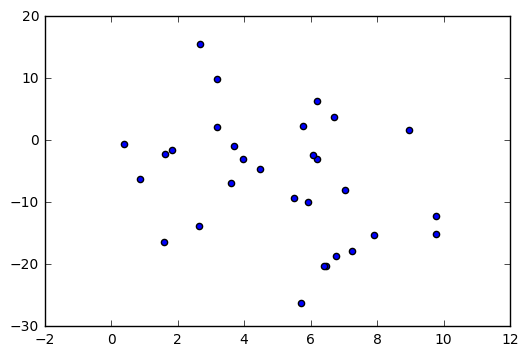

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,1],Y)

In [3]:
beta_ls=np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),Y) #((X'X)^-1)*transpose(X)*Y
print(beta_ls)

[[-0.06554322]
 [-0.1052794 ]
 [ 0.03394741]
 [-2.9660798 ]
 [ 0.01506119]
 [ 2.05907066]]


In [4]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

model=AbstractModel()

model.I = RangeSet(1,nsample)       #Index for observations
model.J = RangeSet(1,nvariables+1)  #Index for variables plus the independent term
model.K = RangeSet(1,1)

model.beta_lm = Var(model.J,domain=Reals,bounds=(-5,5))
model.t = Var(model.I,domain=NonNegativeReals)
model.gamma = Var(domain=NonNegativeReals)  
model.mu = Var(model.I,domain=NonNegativeReals)
model.mu_up = Var(model.I,domain=NonNegativeReals)
model.z = Var(model.I,domain=Binary)

def Obj_rule(model):
	return model.gamma
model.OBJ = Objective(rule=Obj_rule, sense=minimize)

def abs_constraint_upper(model, i): 
    return -(sum((model.beta_lm[j]*X[i-1,j-1]) for j in model.J))-model.t[i]<=-Y[i-1]
model.abs_Constraint_up = Constraint(model.I, rule=abs_constraint_upper)

def abs_constraint_lower(model, i): 
    return -(sum((model.beta_lm[j]*X[i-1,j-1]) for j in model.J))+model.t[i]>=-Y[i-1]
model.abs_Constraint_low = Constraint(model.I, rule=abs_constraint_lower)

def const1(model,i):
    return (model.t[i]+model.mu_up[i]-model.gamma)>= 0
model.Const1 = Constraint(model.I, rule=const1)

def const2(model,i):
    return (model.t[i]-model.mu[i]-model.gamma)<= 0
model.Const2 = Constraint(model.I, rule=const2)

def const3(model,i):
    return (100*model.z[i]-model.mu_up[i])>=0
model.Const3 = Constraint(model.I, rule=const3)

def const4(model,i):
    return (100*(1-model.z[i])-model.mu[i])>=0
model.Const4 = Constraint(model.I, rule=const4)

def const5(model):
    return sum(model.z[i] for i in model.I)==15
model.Const5 = Constraint(rule=const5)

In [5]:
instance=model.create_instance()
results=opt.solve(instance)
print(results)
print("Objective function %f" %instance.OBJ())
#for j in sequence(1,nvariables+1):
for j in instance.J:
    #print("Beta_least_absolute: %.4f" %(instance.beta_lm[j].value))
    print("Beta_median: %.4f;\tBeta_least_square: %.4f;\tDifference: %.4f" %(instance.beta_lm[j].value,beta_ls[j-1],np.subtract(instance.beta_lm[j].value,beta_ls[j-1])))
    
#for i in instance.I:
#    print(instance.t[i].value)
    
#for i in instance.I:
#    print(instance.z[i].value)


Problem: 
- Name: unknown
  Lower bound: 0.148704667006
  Upper bound: 0.148704667006
  Number of objectives: 1
  Number of constraints: 182
  Number of variables: 128
  Number of nonzeros: 751
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 257397
      Number of created subproblems: 257397
  Error rc: 0
  Time: 316.919000149
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Objective function 0.148705
Beta_median: 0.1071;	Beta_least_square: -0.0655;	Difference: 0.1726
Beta_median: -0.0353;	Beta_least_square: -0.1053;	Difference: 0.0700
Beta_median: 0.1203;	Beta_least_square: 0.0339;	Difference: 0.0864
Beta_median: -3.1572;	Beta_least_square: -2.9661;	Difference: -0.1911
Beta_median: -0.0964;	Beta_least_square: 0.0151;	Difference: -0.1114
Beta_median: 2.1765;	Beta_least_square: 2.0591;	Difference: 0.1175
